# Logistic Regression Model

Modelo de regresión logística como baseline simple para la competencia de NLP.


## Imports

In [1]:
# Constantes para preprocesamiento
TFIDF_MAX_FEATURES = 100
ONEHOT_MAX_CATEGORIES = 100
TEST_SIZE = 0.2
RANDOM_STATE = 42

## Constantes

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, auc, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# Para feature engineering
import spacy
import emoji
import re

# Constantes de colores
COLOR_NO_DISASTER = '#3498db'
COLOR_DISASTER = '#e74c3c'
COLOR_GENERAL = '#95a5a6'

## Cargar Datos Raw

In [3]:
BASE_PATH = Path("../.data/raw/")

train_df = pd.read_csv(BASE_PATH / "train.csv")
test_df = pd.read_csv(BASE_PATH / "test.csv")

print(f"Train dataset: {train_df.shape}")
print(f"Test dataset: {test_df.shape}")
print("\nDistribución del target en train:")
print(train_df['target'].value_counts(normalize=True))

Train dataset: (7613, 5)
Test dataset: (3263, 4)

Distribución del target en train:
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


## Feature Engineering

Aplicamos las transformaciones desarrolladas en la exploración:
- Features numéricas del texto
- Limpieza de keywords
- Lematización del texto

In [4]:
# Cargar modelo de spacy
model = spacy.load("en_core_web_sm", disable=["parser", "ner"])
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def clean_tweet(text):
    text = text.lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def lemma_filter(token):
    return token.lemma_ not in stop_words and len(token.lemma_) > 1

def lemmatize_text(text):
    cleaned_text = clean_tweet(text)
    doc = model(cleaned_text)
    return ' '.join([token.lemma_ for token in doc if lemma_filter(token)])

# Aplicar a train
train_df["text_length"] = train_df["text"].str.len()
train_df["word_count"] = train_df["text"].str.split().str.len()
train_df["hashtag_count"] = train_df["text"].str.count("#")
train_df["mention_count"] = train_df["text"].str.count("@")
train_df["url_count"] = train_df["text"].str.count("http")
train_df["uppercase_percentage"] = (
    train_df["text"].str.findall(r"[A-Z]").str.len() / train_df["text_length"]
)
train_df["punctuation_percentage"] = (
    train_df["text"].str.findall(r"[.,!?\"\'()]").str.len() / train_df["text_length"]
)

train_df['keyword_clean'] = train_df['keyword'].str.lower().str.replace('%20', ' ')
print("Lematizando train...")
train_df['text_lemmatized'] = train_df['text'].apply(lemmatize_text)

# Aplicar a test
test_df["text_length"] = test_df["text"].str.len()
test_df["word_count"] = test_df["text"].str.split().str.len()
test_df["hashtag_count"] = test_df["text"].str.count("#")
test_df["mention_count"] = test_df["text"].str.count("@")
test_df["url_count"] = test_df["text"].str.count("http")
test_df["uppercase_percentage"] = (
    test_df["text"].str.findall(r"[A-Z]").str.len() / test_df["text_length"]
)
test_df["punctuation_percentage"] = (
    test_df["text"].str.findall(r"[.,!?\"\'()]").str.len() / test_df["text_length"]
)

test_df['keyword_clean'] = test_df['keyword'].str.lower().str.replace('%20', ' ')
print("Lematizando test...")
test_df['text_lemmatized'] = test_df['text'].apply(lemmatize_text)

print("Feature engineering completado!")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Lematizando train...
Lematizando test...
Lematizando test...
Feature engineering completado!
Train shape: (7613, 14)
Test shape: (3263, 13)
Feature engineering completado!
Train shape: (7613, 14)
Test shape: (3263, 13)


## Split Train/Validation

In [5]:
# Features
numeric_features = [
    'text_length', 'word_count', 'hashtag_count', 'mention_count', 
    'url_count', 'uppercase_percentage', 'punctuation_percentage'
]

X_numeric = train_df[numeric_features]
X_text = train_df['text_lemmatized'].fillna('')
X_keyword = train_df[['keyword_clean']].fillna('unknown')
y = train_df['target']

# Split
X_num_train, X_num_val, X_text_train, X_text_val, X_kw_train, X_kw_val, y_train, y_val = train_test_split(
    X_numeric, X_text, X_keyword, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"Train: {X_num_train.shape[0]} samples")
print(f"Validation: {X_num_val.shape[0]} samples")

Train: 6090 samples
Validation: 1523 samples


## Preprocesamiento

In [6]:
# Scaler para numéricas
scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train)
X_num_val_scaled = scaler.transform(X_num_val)

# TF-IDF para texto
tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, min_df=2, max_df=0.8)
X_text_train_tfidf = tfidf.fit_transform(X_text_train).toarray()
X_text_val_tfidf = tfidf.transform(X_text_val).toarray()

# OneHot para keywords
onehot = OneHotEncoder(sparse_output=False, handle_unknown="infrequent_if_exist", max_categories=ONEHOT_MAX_CATEGORIES)
X_kw_train_encoded = onehot.fit_transform(X_kw_train)
X_kw_val_encoded = onehot.transform(X_kw_val)

# Combinar
X_train = np.hstack([X_num_train_scaled, X_text_train_tfidf, X_kw_train_encoded])
X_val = np.hstack([X_num_val_scaled, X_text_val_tfidf, X_kw_val_encoded])

print(f"Features finales - Train: {X_train.shape}, Val: {X_val.shape}")

Features finales - Train: (6090, 207), Val: (1523, 207)


## Modelo

In [7]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    
    print(f"\n{model_name}:")
    print(f"  F1: {f1:.4f}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")
    
    return {'f1': f1, 'acc': acc, 'prec': prec, 'rec': rec}

## Entrenar Modelo

In [8]:
# Grid search para hiperparámetros
# Definimos combinaciones válidas solver/penalty para evitar errores (lbfgs no soporta l1).
param_grid = [
    {'penalty': ['l2'], 'solver': ['lbfgs'], 'C': [0.1, 1, 10]},
    {'penalty': ['l1'], 'solver': ['liblinear'], 'C': [0.1, 1, 10]},
    {'penalty': ['l1', 'l2'], 'solver': ['saga'], 'C': [0.1, 1, 10]}
]

log_reg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced')

# Si quieres que los errores detengan la búsqueda para debug, usa error_score='raise'
grid = GridSearchCV(log_reg, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print(f"Mejores params: {grid.best_params_}")
print(f"Mejor F1 CV: {grid.best_score_:.4f}")

# Predecir en validation
y_pred = best_model.predict(X_val)
results = evaluate_model(y_val, y_pred, "Logistic Regression")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores params: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Mejor F1 CV: 0.6970

Logistic Regression:
  F1: 0.7020
  Accuracy: 0.7413
  Precision: 0.6946
  Recall: 0.7095
Mejores params: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Mejor F1 CV: 0.6970

Logistic Regression:
  F1: 0.7020
  Accuracy: 0.7413
  Precision: 0.6946
  Recall: 0.7095


In [13]:
# Calcular coeficientes del modelo (Logistic Regression)
tfidf_names = [f"text_{w}" for w in tfidf.get_feature_names_out()]
kw_names = [f"kw_{c.replace('keyword_clean_', '')}" for c in onehot.get_feature_names_out()]

feature_names = numeric_features + tfidf_names + kw_names

coefs = pd.DataFrame({
    'feature': feature_names,
    'coef': best_model.coef_[0],
    'abs_coef': np.abs(best_model.coef_[0])
}).sort_values('abs_coef', ascending=False)

display(coefs.head(10))

,feature,coef,abs_coef
52,text_hiroshima,3.762610,3.762610
86,text_suicide,2.781685,2.781685
131,kw_debris,2.573762,2.573762
176,kw_oil spill,2.497541,2.497541
100,text_wildfire,2.431299,2.431299
56,text_kill,2.388104,2.388104
45,text_fire,2.301123,2.301123
91,text_train,2.287791,2.287791
195,kw_typhoon,2.082162,2.082162
68,text_mass,1.993965,1.993965


## Análisis Final

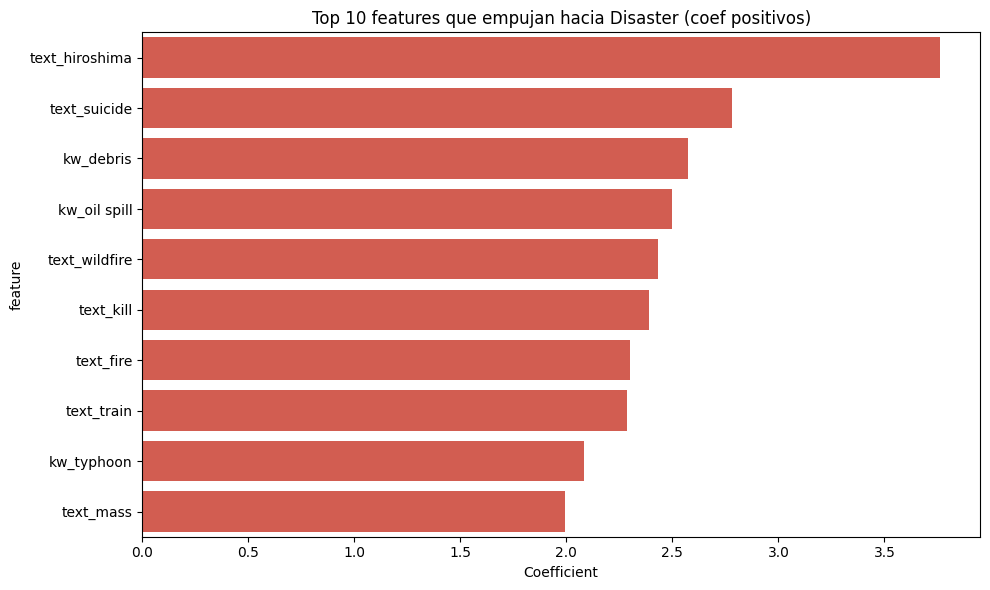

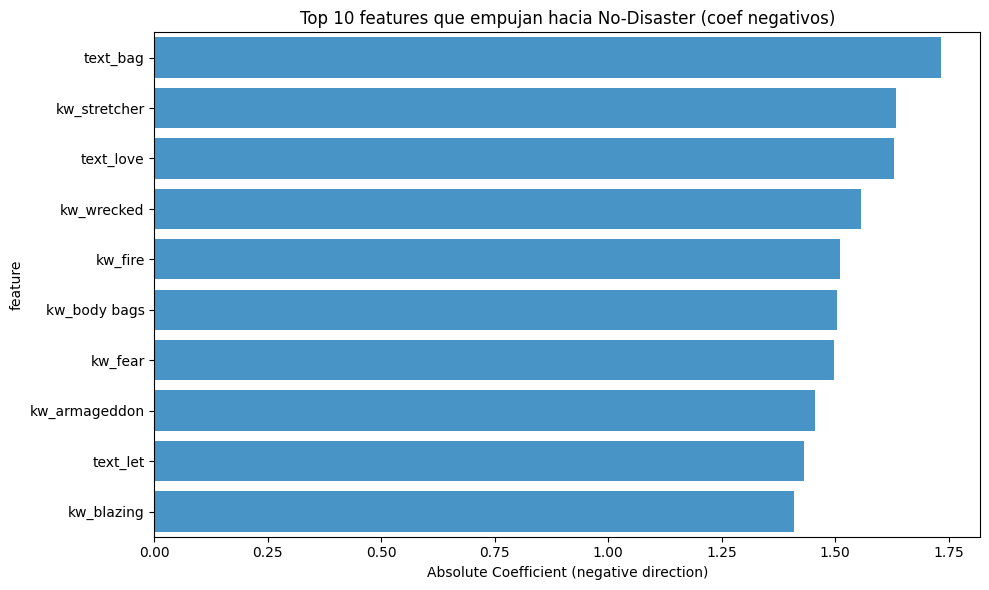

Best Threshold: 0.5538


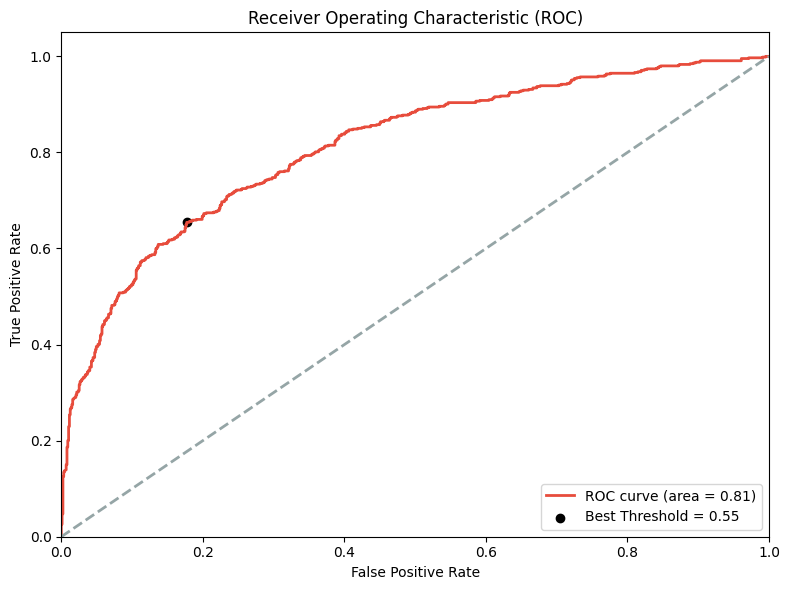

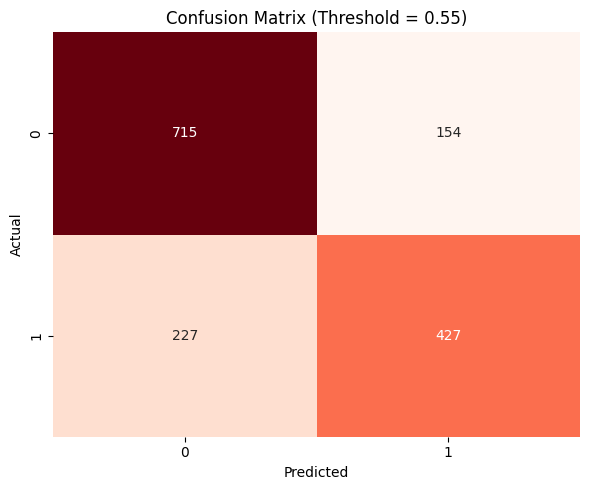

Accuracy: 0.7498
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       869
           1       0.73      0.65      0.69       654

    accuracy                           0.75      1523
   macro avg       0.75      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523



In [14]:
# Feature Importance + ROC + Confusion Matrix (combinado)
# ---------------------------------------------------
# Usamos `coefs` calculado en la celda anterior (debe existir tras el entrenamiento)
top_n = 10

# 1) Features que más empujan hacia Disaster (coef positivos)
pos = coefs.sort_values('coef', ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=pos['coef'], y=pos['feature'], color=COLOR_DISASTER)
plt.title(f"Top {top_n} features que empujan hacia Disaster (coef positivos)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

# 2) Features que más empujan hacia No-Disaster (coef negativos)
neg = coefs.sort_values('coef', ascending=True).head(top_n)

plt.figure(figsize=(10, 6))
# mostramos magnitud positiva para claridad, color distinto
sns.barplot(x= -neg['coef'], y=neg['feature'], color=COLOR_NO_DISASTER)
plt.title(f"Top {top_n} features que empujan hacia No-Disaster (coef negativos)")
plt.xlabel("Absolute Coefficient (negative direction)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# ROC
y_probs = best_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

# Best threshold (Youden's J)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print(f'Best Threshold: {best_thresh:.4f}')

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=COLOR_DISASTER, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color=COLOR_GENERAL, lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Best Threshold = {best_thresh:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# Confusion Matrix (con el threshold optimizado)
y_pred_opt = (y_probs > best_thresh).astype(int)
cm = confusion_matrix(y_val, y_pred_opt)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title(f'Confusion Matrix (Threshold = {best_thresh:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Metrics
print(f'Accuracy: {accuracy_score(y_val, y_pred_opt):.4f}')
print(classification_report(y_val, y_pred_opt))

In [15]:
# Procesar test
X_test_num = test_df[numeric_features]
X_test_text = test_df['text_lemmatized'].fillna('')
X_test_kw = test_df[['keyword_clean']].fillna('unknown')

X_test_num_scaled = scaler.transform(X_test_num)
X_test_text_tfidf = tfidf.transform(X_test_text).toarray()
X_test_kw_encoded = onehot.transform(X_test_kw)

X_test = np.hstack([X_test_num_scaled, X_test_text_tfidf, X_test_kw_encoded])

# Predicciones
y_test_pred = best_model.predict(X_test)

## Submission

In [16]:
# Submission
submission = pd.DataFrame({'id': test_df['id'], 'target': y_test_pred})
submission_path = Path("../.data/submission")
submission_path.mkdir(exist_ok=True)
submission.to_csv(submission_path / "logistic_regression_submission.csv", index=False)

print(f"Submission guardada en {submission_path / 'logistic_regression_submission.csv'}")

Submission guardada en ..\.data\submission\logistic_regression_submission.csv
